In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from alpha_excel2.core.facade import AlphaExcel

## 1. AlphaExcel 초기화

In [ ]:
ae = AlphaExcel(
    start_time='2016-01-28',
    end_time='2024-12-31',
    universe=None,
    config_path='../config'
)

print(f"기간: {ae._start_time} ~ {ae._end_time}")
print(f"유니버스 크기: {ae._universe_mask._data.shape}")

Config file not found: ..\config\preprocessing.yaml. Using empty config.


Time Range: 2016-01-28 00:00:00 to 2024-12-31 00:00:00
Universe Shape: (2192, 2926)


## 2. 데이터 필드 로딩

In [ ]:
f = ae.field
o = ae.ops

# 원본 데이터 필드 로딩
adj_close = f('fnguide_adj_close')
market_cap = f('fnguide_market_cap')
industry_group = f('fnguide_industry_group')

print("데이터 필드 로딩 완료.")

Data fields loaded successfully.


## 3. 일간 수익률 계산

In [ ]:
# 전일 종가 가져오기
prev_close = o.ts_delay(adj_close, window=1)

# 수익률 계산
returns = (adj_close - prev_close) / prev_close

print("[일간 수익률 통계]")
returns_df = returns.to_df()
print(f"평균 수익률: {returns_df.mean().mean():.6f}")
print(f"표준편차: {returns_df.std().mean():.6f}")

[Daily Returns Statistics]
Mean Return: -0.000168
Std Dev: 0.033828


## 4. 동종업체 수익률 계산

In [ ]:
# 동일가중 동종업체 수익률
ew_numerator = o.group_sum(returns, industry_group) - returns
ew_denominator = o.group_count(industry_group) - 1
ew_peer_return = ew_numerator / ew_denominator

# 시가총액가중 동종업체 수익률
vw_numerator = o.group_sum(market_cap * returns, industry_group) - market_cap * returns
vw_denominator = o.group_sum(market_cap, industry_group) - market_cap
vw_peer_return = vw_numerator / vw_denominator

print("[동종업체 수익률 통계]")
print(f"동일가중 평균: {ew_peer_return.to_df().mean().mean():.6f}")
print(f"시총가중 평균: {vw_peer_return.to_df().mean().mean():.6f}")

[Peer Returns Statistics]
EW Peer Return - Mean: 0.000187
VW Peer Return - Mean: 0.000592
VW Peer Return - Mean: 0.000592


---
# 테스트 1: 동종업체 수익률을 시그널로 사용

**가설**: 동종업체 수익률이 가장 높은 종목이 향후 수익률도 높다

**분석**: 동일가중 동종업체 수익률 시그널로 상위 1%, 5%, 10%, 20% 선택 비교

## 테스트 1.1: 동일가중 동종업체 수익률 시그널 (상위 1%, 5%, 10%, 20%)

In [ ]:
# 스케일러 설정
ae.set_scaler('LongOnly')

# 임계값 정의
thresholds = {
    '상위 1%': 0.99,
    '상위 5%': 0.95,
    '상위 10%': 0.90,
    '상위 20%': 0.80
}

# 동일가중 동종업체 수익률 시그널 (다양한 임계값)
test1_ew_results = {}

for label, threshold in thresholds.items():
    # 동일가중 시그널: ew_peer_return으로 상위 N%
    ranked_ew_peer = o.rank(ew_peer_return)
    mask = ranked_ew_peer > threshold
    signal = ew_peer_return * mask
    
    weights = ae.to_weights(signal)
    portfolio_returns = ae.to_portfolio_returns(weights)
    pnl = portfolio_returns.to_df().sum(axis=1)
    cum = pnl.cumsum()
    sharpe = pnl.mean() / pnl.std() * np.sqrt(252)
    
    test1_ew_results[label] = {
        'pnl': pnl,
        'cum': cum,
        'sharpe': sharpe
    }
    
    print(f"[테스트 1 - {label} 동일가중 동종업체]")
    print(f"샤프 비율: {sharpe:.2f}")
    print(f"총 수익률: {cum.iloc[-1]:.4f}\n")

[Test 1 - Top 1% EW Peer Return]
Sharpe: 1.17
Total Return: 2.4312

[Test 1 - Top 5% EW Peer Return]
Sharpe: 1.78
Total Return: 3.4169

[Test 1 - Top 5% EW Peer Return]
Sharpe: 1.78
Total Return: 3.4169

[Test 1 - Top 10% EW Peer Return]
Sharpe: 1.81
Total Return: 3.3974

[Test 1 - Top 10% EW Peer Return]
Sharpe: 1.81
Total Return: 3.3974

[Test 1 - Top 20% EW Peer Return]
Sharpe: 1.78
Total Return: 3.2204

[Test 1 - Top 20% EW Peer Return]
Sharpe: 1.78
Total Return: 3.2204



## 테스트 1.2: 결과 비교

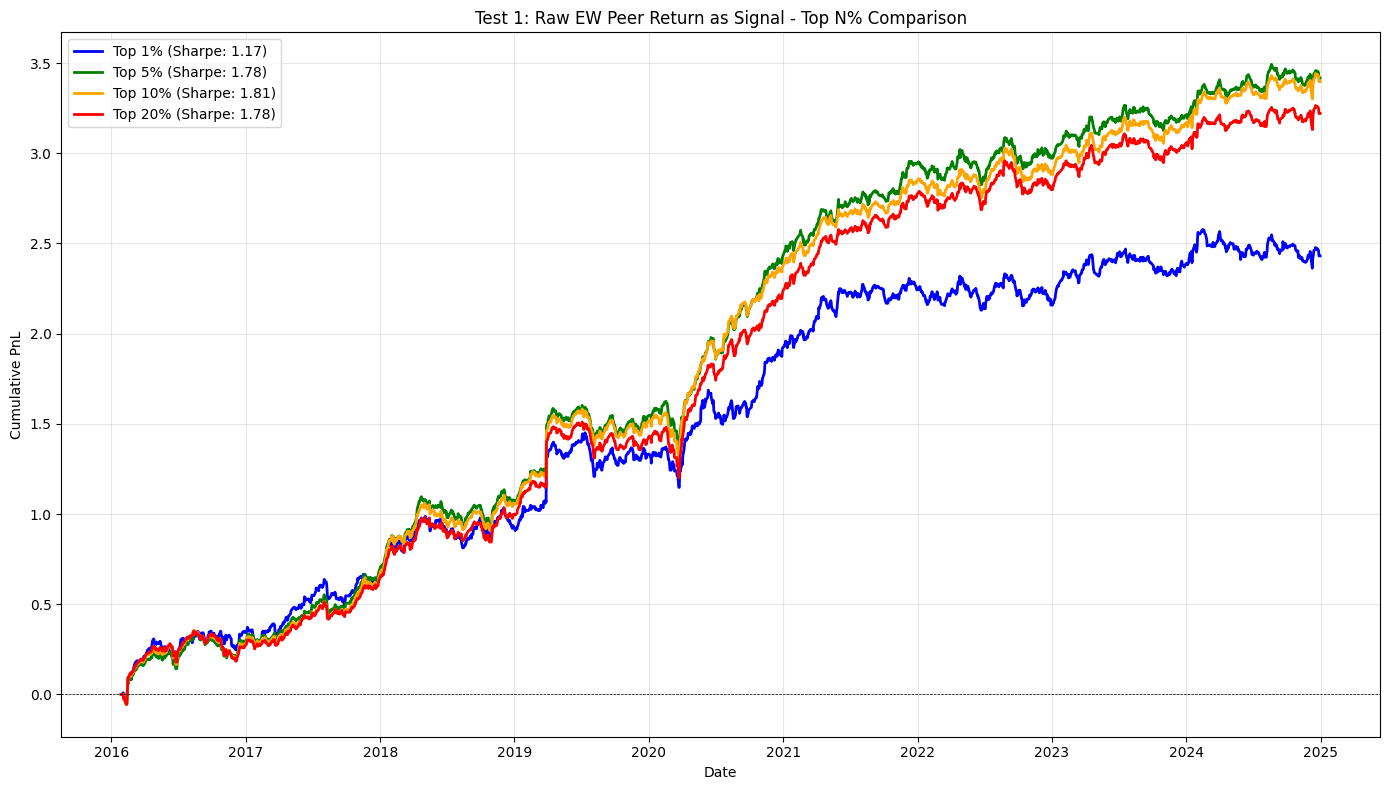


[Test 1 Results - EW Peer Return Signal]
Strategy          Sharpe Total Return
--------------- -------- ------------
Top 1%              1.17       2.4312
Top 5%              1.78       3.4169
Top 10%             1.81       3.3974
Top 20%             1.78       3.2204


In [ ]:
# 그래프 비교 - 모든 동일가중 시그널을 한 그래프에
plt.figure(figsize=(14, 8))

colors = ['blue', 'green', 'orange', 'red']
for (label, result), color in zip(test1_ew_results.items(), colors):
    plt.plot(result['cum'].index, result['cum'].values, 
             label=f"{label} (샤프: {result['sharpe']:.2f})", 
             linewidth=2, color=color)

plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('날짜')
plt.ylabel('누적 수익')
plt.title('테스트 1: 동종업체 수익률 시그널 - 상위 N% 비교')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 통계 출력
print("\n[테스트 1 결과 - 동일가중 동종업체 수익률 시그널]")
print(f"{'전략':<15} {'샤프':>8} {'총수익률':>12}")
print(f"{'-'*15} {'-'*8} {'-'*12}")
for label, result in test1_ew_results.items():
    print(f"{label:<15} {result['sharpe']:>8.2f} {result['cum'].iloc[-1]:>12.4f}")

---
# 테스트 2: 동종업체 대비 초과수익을 시그널로 사용

**가설**: 동종업체 대비 초과수익이 가장 높은 종목이 계속 초과수익을 낸다

**분석**: 동일가중 초과수익 시그널로 상위 1%, 5%, 10%, 20% 선택 비교

## 테스트 2.1: 동일가중 초과수익 시그널 (상위 1%, 5%, 10%, 20%)

In [ ]:
# 동일가중 초과수익 시그널 (다양한 임계값)
test2_ew_results = {}

for label, threshold in thresholds.items():
    # 동일가중 시그널: (returns - ew_peer_return)으로 상위 N%
    ew_outperformance = returns - ew_peer_return
    ranked_ew_outperf = o.rank(ew_outperformance)
    mask = ranked_ew_outperf > threshold
    signal = ew_outperformance * mask
    
    weights = ae.to_weights(signal)
    portfolio_returns = ae.to_portfolio_returns(weights)
    pnl = portfolio_returns.to_df().sum(axis=1)
    cum = pnl.cumsum()
    sharpe = pnl.mean() / pnl.std() * np.sqrt(252)
    
    test2_ew_results[label] = {
        'pnl': pnl,
        'cum': cum,
        'sharpe': sharpe
    }
    
    print(f"[테스트 2 - {label} 동일가중 초과수익]")
    print(f"샤프 비율: {sharpe:.2f}")
    print(f"총 수익률: {cum.iloc[-1]:.4f}\n")

[Test 2 - Top 1% EW Outperformance]
Sharpe: 2.70
Total Return: 12.9924

[Test 2 - Top 5% EW Outperformance]
Sharpe: 2.11
Total Return: 5.7966

[Test 2 - Top 5% EW Outperformance]
Sharpe: 2.11
Total Return: 5.7966

[Test 2 - Top 10% EW Outperformance]
Sharpe: 1.81
Total Return: 4.1392

[Test 2 - Top 10% EW Outperformance]
Sharpe: 1.81
Total Return: 4.1392

[Test 2 - Top 20% EW Outperformance]
Sharpe: 1.55
Total Return: 3.1179

[Test 2 - Top 20% EW Outperformance]
Sharpe: 1.55
Total Return: 3.1179



## 테스트 2.2: 결과 비교

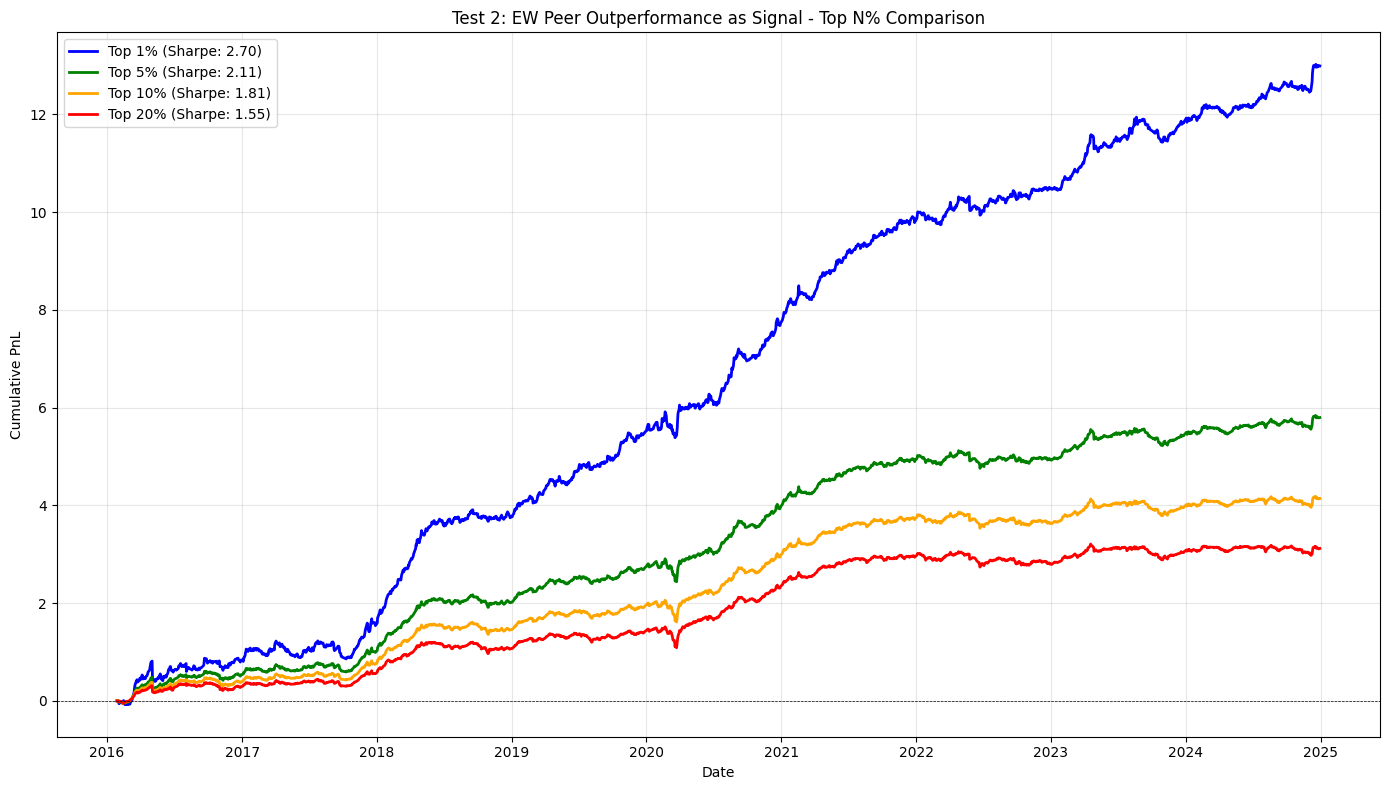


[Test 2 Results - EW Outperformance Signal]
Strategy          Sharpe Total Return
--------------- -------- ------------
Top 1%              2.70      12.9924
Top 5%              2.11       5.7966
Top 10%             1.81       4.1392
Top 20%             1.55       3.1179


In [ ]:
# 그래프 비교 - 모든 동일가중 초과수익 시그널을 한 그래프에
plt.figure(figsize=(14, 8))

colors = ['blue', 'green', 'orange', 'red']
for (label, result), color in zip(test2_ew_results.items(), colors):
    plt.plot(result['cum'].index, result['cum'].values, 
             label=f"{label} (샤프: {result['sharpe']:.2f})", 
             linewidth=2, color=color)

plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('날짜')
plt.ylabel('누적 수익')
plt.title('테스트 2: 동종업체 대비 초과수익 시그널 - 상위 N% 비교')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 통계 출력
print("\n[테스트 2 결과 - 동일가중 초과수익 시그널]")
print(f"{'전략':<15} {'샤프':>8} {'총수익률':>12}")
print(f"{'-'*15} {'-'*8} {'-'*12}")
for label, result in test2_ew_results.items():
    print(f"{label:<15} {result['sharpe']:>8.2f} {result['cum'].iloc[-1]:>12.4f}")

---
# 요약: 상위 N% 성과 비교

In [ ]:
# 요약 비교
print("=" * 70)
print("최종 비교: 동일가중 동종업체 수익률 전략")
print("=" * 70)

print("\n[테스트 1: 동종업체 수익률 시그널]")
print(f"{'임계값':<15} {'샤프':>8} {'총수익률':>12}")
print(f"{'-'*15} {'-'*8} {'-'*12}")
for label, result in test1_ew_results.items():
    print(f"{label:<15} {result['sharpe']:>8.2f} {result['cum'].iloc[-1]:>12.4f}")

print("\n[테스트 2: 동종업체 대비 초과수익 시그널]")
print(f"{'임계값':<15} {'샤프':>8} {'총수익률':>12}")
print(f"{'-'*15} {'-'*8} {'-'*12}")
for label, result in test2_ew_results.items():
    print(f"{label:<15} {result['sharpe']:>8.2f} {result['cum'].iloc[-1]:>12.4f}")

print("\n" + "=" * 70)

FINAL COMPARISON: EW PEER RETURN STRATEGIES

[Test 1: Raw EW Peer Return as Signal]
Threshold         Sharpe Total Return
--------------- -------- ------------
Top 1%              1.17       2.4312
Top 5%              1.78       3.4169
Top 10%             1.81       3.3974
Top 20%             1.78       3.2204

[Test 2: EW Peer Outperformance as Signal]
Threshold         Sharpe Total Return
--------------- -------- ------------
Top 1%              2.70      12.9924
Top 5%              2.11       5.7966
Top 10%             1.81       4.1392
Top 20%             1.55       3.1179



## 주요 발견사항

**테스트 1 (동종업체 수익률)**:
- 동종업체 수익률 시그널을 사용한 포트폴리오 집중도 효과 비교
- 상위 1%, 5%, 10%, 20% 선택 분석
- 동일가중(EW) 동종업체 수익률로 순위 매김

**테스트 2 (초과수익)**:
- 동종업체 대비 자기 초과수익을 시그널로 사용
- 시그널 = returns - ew_peer_return
- 상대적 우위 종목의 지속성 테스트

**집중도 분석**:
- 상위 1%: 가장 집중, 잠재적 알파는 높지만 변동성도 높음
- 상위 5%: 중간 집중도
- 상위 10%: 균형 잡힌 접근
- 상위 20%: 더 분산, 잠재적 낮은 변동성

## 상관관계 분석: 동종업체 수익률 vs 초과수익 시그널

CORRELATION ANALYSIS: RAW SIGNAL vs OUTPERFORMANCE SIGNAL

Correlation of daily PnL between strategies:

Top 1%          Correlation: 0.1865
Top 5%          Correlation: 0.3981
Top 10%         Correlation: 0.5022
Top 20%         Correlation: 0.5737



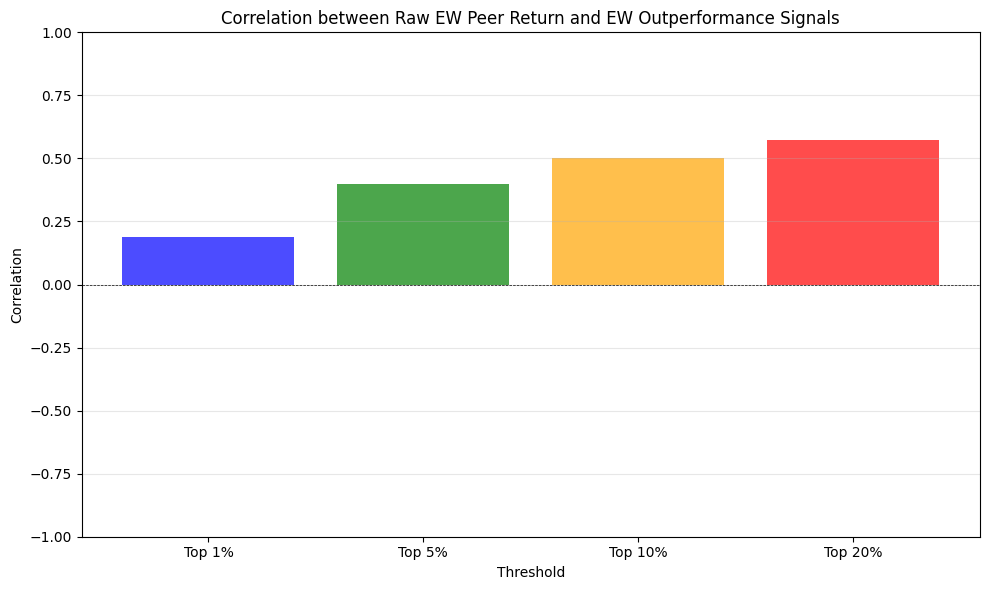

: 

In [ ]:
# 테스트 1과 테스트 2의 각 임계값별 상관관계 계산
print("=" * 70)
print("상관관계 분석: 동종업체 수익률 vs 초과수익 시그널")
print("=" * 70)
print("\n전략 간 일일 수익 상관관계:\n")

correlation_results = {}

for label in thresholds.keys():
    test1_pnl = test1_ew_results[label]['pnl']
    test2_pnl = test2_ew_results[label]['pnl']
    
    # 상관관계 계산
    correlation = test1_pnl.corr(test2_pnl)
    correlation_results[label] = correlation
    
    print(f"{label:<15} 상관관계: {correlation:.4f}")

print("\n" + "=" * 70)

# 상관관계 시각화
plt.figure(figsize=(10, 6))
labels = list(correlation_results.keys())
corrs = list(correlation_results.values())

plt.bar(labels, corrs, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('임계값')
plt.ylabel('상관관계')
plt.title('동종업체 수익률과 초과수익 시그널 간 상관관계')
plt.ylim(-1, 1)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()